In [1]:
import warnings
warnings.filterwarnings('ignore')

import string
import unicodedata

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from typing import Tuple
from itertools import chain

In [2]:
plt.style.use("./figures/thesis.mplstyle")
sns.set_theme()

In [3]:
# load in the data from the excel file
df_data = pd.read_excel("./data/dvlog.xlsx")
df_data.head()

,video_id,label,key,gender,duration,channelId,transcript,transcript annotated
0,0,depression,2s3EFyjUmfs,f,823.31,UCWx_Fqt2AziUyAHVjgUH1PQ,so I wanted to come on here and sit down with ...,[{'text': 'so I wanted to come on here and sit...
1,1,depression,MCaKQvEofrE,f,436.65,UCxxhKhiRPfPe_U78ao3FKLw,hello guys it's me again and i'm going to talk...,"[{'text': 'hello guys', 'start': 9.599, 'durat..."
2,2,depression,6o-DlNR_cIs,m,835.83,UCCXKRG3s-auYMFIAKjeey_Q,welcome back to another video today I'm gonna ...,"[{'text': ""welcome back to another video today..."
3,3,depression,gxZjgt3Gnug,m,420.61,UCuhfaNXfRLFfVVc6dSNoyhA,hi everybody and welcome to and in the clouds ...,[{'text': 'hi everybody and welcome to and in ...
4,4,depression,oc72xdTxJ50,f,444.55,UCbiKXPwk590XYYqqCEbtgoA,"Hey, Hey Me and my crown Me and my hairy hair ...","[{'text': 'Hey, Hey', 'start': 1.04, 'duration..."


In [4]:
# get some overall statistics about the overall dataset
print(f"size: {len(df_data)}")

df_data.groupby("label").count()["video_id"]

size: 961


label
depression    555
normal        406
Name: video_id, dtype: int64

## Filter the transcripts
Now we will filter out the transcripts that were unavailable and check the 

In [5]:
# now filter out the videos without a transcript
df_filter_data = df_data[df_data["transcript"] != "transcript not available anymore"]

# print the new sizes
print(f"size: {len(df_filter_data)}")
print(df_filter_data.groupby("label").count()["video_id"])

size: 796
label
depression    432
normal        364
Name: video_id, dtype: int64


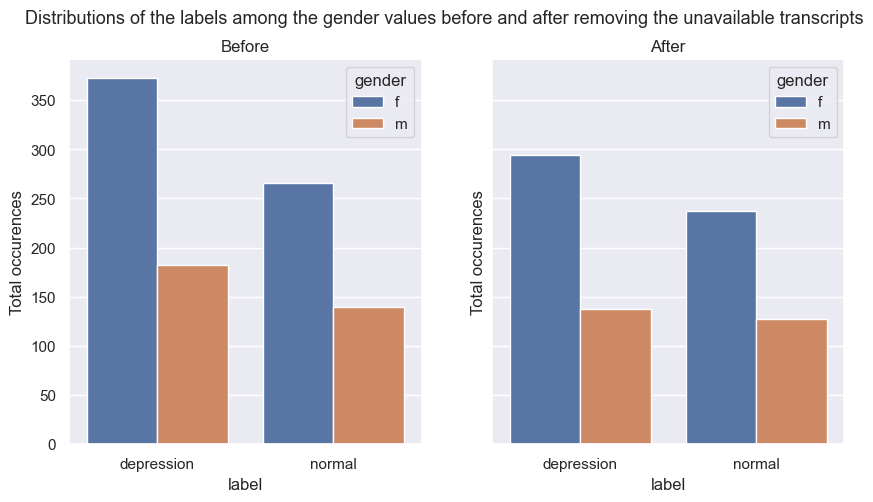

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
# Get the difference between the distributions before and after removing the transcripts
norm_data = df_data.groupby(["gender", "label"]).agg(count_occ=("video_id", "count")).reset_index()
filter_data = df_filter_data.groupby(["gender", "label"]).agg(count_occ=("video_id", "count")).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.barplot(x='label', y='count_occ', hue='gender', data=norm_data, ax=ax1)
sns.barplot(x='label', y='count_occ', hue='gender', data=filter_data, ax=ax2)

ax1.set_ylabel("Total occurences")
ax1.set_title('Before')

ax2.set_ylabel("Total occurences")
ax2.set_title('After')

fig.suptitle("Distributions of the labels among the gender values before and after removing the unavailable transcripts", fontsize=13)
plt.show()
fig.savefig("figures/filtered_dvlog.eps", format="eps")

In [7]:
filter_data

,gender,label,count_occ
0,f,depression,294
1,f,normal,237
2,m,depression,138
3,m,normal,127


In [8]:
# Get the difference between the distributions of the duration
df_filter_data.groupby(["label", "gender"]).agg(avg_duration=("duration", "mean"))

avg_duration
label      gender              
depression f         653.420816
           m         551.829783
normal     f         585.139409
           m         452.752756

## Going deeper into the textual modality

In [9]:
# we first have to do some basic tokenization
def preprocess_string(text: str, stop_words: set = set(stopwords.words("english")), unicode_pattern: str = "NFKD", without_stop: bool = False, with_lemma: bool = False) -> str:
    text = text.replace("\n", " ").strip()  # Remove newlines and trailing whitespace
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove puctuation with lookup table
    text = text.lower()  # Lowercase
    if without_stop:
        text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = text.translate(str.maketrans("", "", string.digits))  # Remove all numbers with lookup table
    
    # Remove excess whitespace in between words
    # E.g. the sentence "for 10 days" becomes "for days" instead of "for  days" with two spaces
    text = " ".join(text.split())
    text = unicodedata.normalize(unicode_pattern, text)  # Strip accents from characters
    
    # Lemmatization
    if with_lemma:
        lemmanizer = nltk.stem.WordNetLemmatizer()
        text = " ".join([lemmanizer.lemmatize(word) for word in text.split()])

    return text

# preprocess each string and get it with and without stop words included for further analysis
df_filter_data["preprocessed_with_stop"] = df_filter_data["transcript"].apply(preprocess_string)
df_filter_data["preprocessed_without_stop"] = df_filter_data["transcript"].apply(lambda x: preprocess_string(x, without_stop=True))
df_filter_data["preprocessed_without_stop_with_lemma"] = df_filter_data["transcript"].apply(lambda x: preprocess_string(x, without_stop=True, with_lemma=True))
df_filter_data.head(3)

,video_id,label,key,gender,duration,channelId,transcript,transcript annotated,preprocessed_with_stop,preprocessed_without_stop,preprocessed_without_stop_with_lemma
0,0,depression,2s3EFyjUmfs,f,823.31,UCWx_Fqt2AziUyAHVjgUH1PQ,so I wanted to come on here and sit down with ...,[{'text': 'so I wanted to come on here and sit...,so i wanted to come on here and sit down with ...,wanted come sit guys kind talk vent really str...,wanted come sit guy kind talk vent really stru...
1,1,depression,MCaKQvEofrE,f,436.65,UCxxhKhiRPfPe_U78ao3FKLw,hello guys it's me again and i'm going to talk...,"[{'text': 'hello guys', 'start': 9.599, 'durat...",hello guys its me again and im going to talk t...,hello guys im going talk today survive depress...,hello guy im going talk today survive depressi...
2,2,depression,6o-DlNR_cIs,m,835.83,UCCXKRG3s-auYMFIAKjeey_Q,welcome back to another video today I'm gonna ...,"[{'text': ""welcome back to another video today...",welcome back to another video today im gonna b...,welcome back another video today im gonna expl...,welcome back another video today im gonna expl...


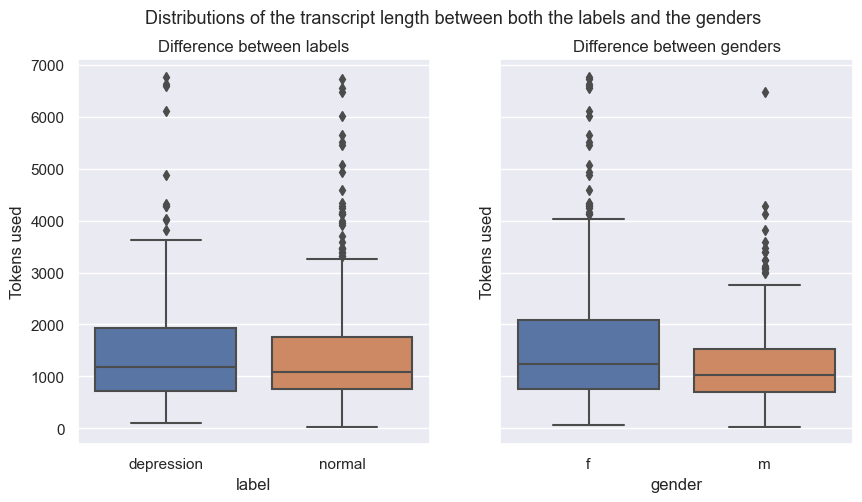

In [10]:
# Get the amount of tokens used for per gender
df_filter_data["num_tokens"] = df_filter_data["preprocessed_with_stop"].apply(lambda x: len(x.split()))

# plot the difference in length of the transcripts
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.boxplot(x='label', y='num_tokens', data=df_filter_data, ax=ax1)
sns.boxplot(x='gender', y='num_tokens', data=df_filter_data, ax=ax2)

ax1.set_ylabel("Tokens used")
ax1.set_title('Difference between labels')

ax2.set_ylabel("Tokens used")
ax2.set_title('Difference between genders')

fig.suptitle("Distributions of the transcript length between both the labels and the genders", fontsize=13)
plt.show()

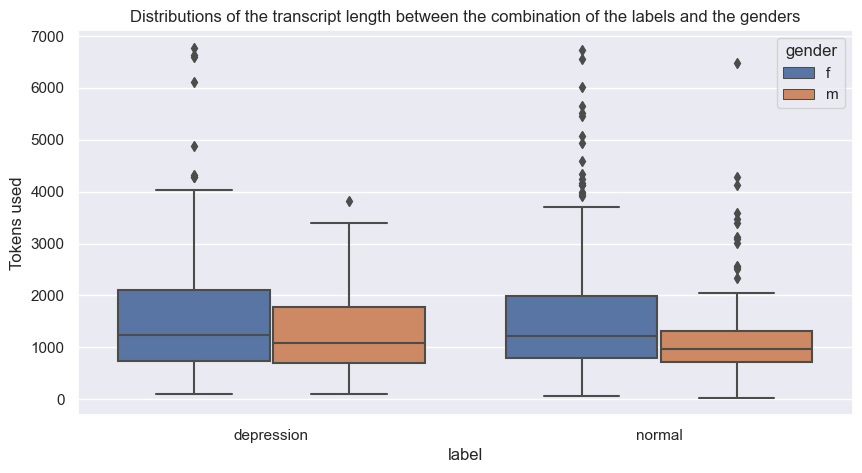

In [11]:
# plot the difference between the combination of gender and label
fig, ax = plt.subplots()
sns.boxplot(x='label', y='num_tokens', hue='gender', data=df_filter_data, ax=ax)

ax.set_ylabel("Tokens used")
ax.set_title('Distributions of the transcript length between the combination of the labels and the genders')
plt.show()

### checking for specific word use using N-grams

In [12]:
def get_top_n_words(df: pd.DataFrame, column: str, n: int, col_filter: Tuple[str, str] | Tuple[str, str, str, str], ngram: int):

    if len(col_filter) == 2:
        # we specify one column and one particular value
        filtered = df[df[col_filter[0]] == col_filter[1]][column]
    else:
        # we specify two particular values from two columns
        filtered = df[(df[col_filter[0]] == col_filter[1]) & (df[col_filter[2]] == col_filter[3])][column]
    
    # put all the words to an ngram
    sequences = [sequence.split() for sequence in filtered]

    if ngram > 1:
        sequences = [list(ngrams(sequence, ngram)) for sequence in sequences]
    
    # use the Counter to count all the occurences
    counter = Counter(list(chain.from_iterable(sequences)))
    
    # return the top n words from the counter
    return counter.most_common(n)

In [13]:
# get the difference in top n words without stop words between both labels
column = "preprocessed_without_stop_with_lemma"
depr1 = get_top_n_words(df_filter_data, column, 5, ("label", "depression"), 1)
depr2 = get_top_n_words(df_filter_data, column, 5, ("label", "depression"), 2)

norm1 = get_top_n_words(df_filter_data, column, 5, ("label", "normal"), 1)
norm2 = get_top_n_words(df_filter_data, column, 5, ("label", "normal"), 2)

# put it into a dataframe
df_list = []
for depr, norm in zip(depr1, norm1):
    df_list.append(depr + norm)
for depr, norm in zip(depr2, norm2):
    df_list.append(depr + norm)

df = pd.DataFrame(df_list, columns=["depressed", "d_count", "normal", "n_count"])
df.head(10)

,depressed,d_count,normal,n_count
0,like,10904,like,8935
1,im,7656,im,4640
2,know,7072,know,4044
3,dont,4523,um,3855
4,really,3932,really,3599
5,"(dont, know)",1265,"(dont, know)",802
6,"(feel, like)",932,"(im, gonna)",795
7,"(im, gonna)",884,"(im, going)",647
8,"(im, going)",693,"(little, bit)",448
9,"(dont, want)",573,"(feel, like)",390


In [14]:
# get the difference in top n words without stop words between both labels combined with gender
n_gram_size = 3
column = "preprocessed_without_stop"

depr_f = get_top_n_words(df_filter_data, column, 10, ("label", "depression", "gender", "f"), n_gram_size)
depr_m = get_top_n_words(df_filter_data, column, 10, ("label", "depression", "gender", "m"), n_gram_size)

norm_f = get_top_n_words(df_filter_data, column, 10, ("label", "normal", "gender", "f"), n_gram_size)
norm_m = get_top_n_words(df_filter_data, column, 10, ("label", "normal", "gender", "m"), n_gram_size)

df_list = []
columns= ["depressed female", 1, "depressed male", 2, "normal female", 3, "normal male", 4]
for x1, x2, x3, x4 in zip(depr_f, depr_m, norm_f, norm_m):
    df_list.append(x1 + x2 + x3 + x4)

df = pd.DataFrame(df_list, columns=columns)
df.head(10)             

,depressed female,1,depressed male,2,normal female,3,normal male,4
0,"(im, gonna, go)",95,"(feel, like, im)",25,"(new, student, dialogue)",70,"(new, student, dialogue)",56
1,"(dont, know, im)",90,"(dont, know, im)",23,"(im, gonna, go)",68,"(like, dont, know)",17
2,"(like, dont, know)",88,"(im, gonna, try)",21,"(like, dont, know)",54,"(dont, know, im)",14
3,"(feel, like, im)",85,"(dont, even, know)",19,"(think, im, gonna)",41,"(hit, like, button)",12
4,"(dont, even, know)",70,"(know, dont, know)",18,"(dont, know, im)",37,"(achieved, true, dialogue)",11
5,"(dont, feel, like)",52,"(know, im, going)",18,"(dont, even, know)",32,"(think, dialogue, component)",11
6,"(dont, know, like)",45,"(im, gonna, go)",17,"(im, going, show)",32,"(im, going, try)",10
7,"(im, gonna, get)",44,"(like, dont, know)",14,"(every, single, day)",32,"(dont, really, know)",10
8,"(dont, know, dont)",44,"(know, whats, going)",13,"(im, gonna, put)",29,"(thats, pretty, much)",10
9,"(know, dont, know)",43,"(dont, want, go)",13,"(im, going, go)",28,"(achieve, true, dialogue)",10


#### Filter out words used by other labels


In [15]:
def get_filtered_top_n_words(df: pd.DataFrame, column: str, n: int, col_filter: Tuple[str, str] | Tuple[str, str, str, str], ngram: int):
    """"""

    if len(col_filter) == 2:
        # we specify one column and one particular value
        filtered = df[df[col_filter[0]] == col_filter[1]][column]
        opposites = df[df[col_filter[0]] != col_filter[1]][column]
    else:
        # we specify two particular values from two columns
        filtered = df[(df[col_filter[0]] == col_filter[1]) & (df[col_filter[2]] == col_filter[3])][column]
        opposites = df[~((df[col_filter[0]] == col_filter[1]) & (df[col_filter[2]] == col_filter[3]))][column]

    # put all the words to an ngram
    selected_sequences = [sequence.split() for sequence in filtered]
    opposite_sequences = [sequence.split() for sequence in opposites]

    if ngram > 1:
        selected_sequences = [list(ngrams(sequence, ngram)) for sequence in selected_sequences]
        opposite_sequences = [list(ngrams(sequence, ngram)) for sequence in opposite_sequences]
    
    # filter out the unwanted words, by making the opposites a filter set
    selected_sequences = list(chain.from_iterable(selected_sequences))
    opposite_sequences = set(list(chain.from_iterable(opposite_sequences)))

    # do the filtering
    sequences = [sequence for sequence in selected_sequences if sequence not in opposite_sequences]
    
    # use the Counter to count all the occurences
    counter = Counter(sequences)
    
    # return the top n words from the counter
    return counter.most_common(n)

In [16]:
# get the difference in top n words without stop words between both labels
column = "preprocessed_without_stop_with_lemma"
# column = "preprocessed_without_stop"

depr1 = get_filtered_top_n_words(df_filter_data, column, 5, ("label", "depression"), 1)
depr2 = get_filtered_top_n_words(df_filter_data, column, 5, ("label", "depression"), 2)

norm1 = get_filtered_top_n_words(df_filter_data, column, 5, ("label", "normal"), 1)
norm2 = get_filtered_top_n_words(df_filter_data, column, 5, ("label", "normal"), 2)

# put it into a dataframe
df_list = []
for depr, norm in zip(depr1, norm1):
    df_list.append(depr + norm)
for depr, norm in zip(depr2, norm2):
    df_list.append(depr + norm)

df = pd.DataFrame(df_list, columns=["depressed", "d_count", "normal", "n_count"])
df.head(10)

,depressed,d_count,normal,n_count
0,psychiatrist,77,clemson,112
1,antidepressant,69,stereotype,75
2,selfesteem,37,component,59
3,ptsd,36,tammy,53
4,worthless,33,shade,42
5,"(panic, attack)",132,"(student, dialogue)",162
6,"(anxiety, depression)",88,"(new, student)",140
7,"(im, depressed)",47,"(active, voice)",73
8,"(depression, know)",43,"(true, dialogue)",72
9,"(know, depression)",35,"(dialogue, um)",58


In [23]:
### get the difference in top n words without stop words between both labels combined with gender
n_gram_size = 2
column = "preprocessed_without_stop_with_lemma"
# column = "preprocessed_without_stop"

depr_f = get_filtered_top_n_words(df_filter_data, column, 10, ("label", "depression", "gender", "f"), n_gram_size)
depr_m = get_filtered_top_n_words(df_filter_data, column, 10, ("label", "depression", "gender", "m"), n_gram_size)

norm_f = get_filtered_top_n_words(df_filter_data, column, 10, ("label", "normal", "gender", "f"), n_gram_size)
norm_m = get_filtered_top_n_words(df_filter_data, column, 10, ("label", "normal", "gender", "m"), n_gram_size)

df_list = []
columns= ["depressed female", 1, "depressed male", 2, "normal female", 3, "normal male", 4]
for x1, x2, x3, x4 in zip(depr_f, depr_m, norm_f, norm_m):
    df_list.append(x1 + x2 + x3 + x4)

df = pd.DataFrame(df_list, columns=columns)
df.head(10)   

,depressed female,1,depressed male,2,normal female,3,normal male,4
0,"(like, million)",12,"(ice, bath)",14,"(peer, pressure)",25,"(treasure, hunt)",27
1,"(lip, smacker)",12,"(low, testosterone)",9,"(cosmetology, school)",21,"(jerk, bait)",22
2,"(depressed, people)",11,"(beat, as)",7,"(passive, voice)",18,"(mr, gate)",15
3,"(super, depressed)",10,"(wim, hof)",7,"(single, crochet)",16,"(assassin, creed)",15
4,"(chronic, pain)",10,"(vera, juice)",7,"(getting, started)",15,"(adult, adhd)",14
5,"(im, angry)",10,"(bed, didnt)",6,"(rite, aid)",15,"(sleep, paralysis)",13
6,"(leave, room)",10,"(type, depression)",6,"(lip, liner)",15,"(governing, body)",12
7,"(pain, crisis)",10,"(game, cave)",6,"(active, sentence)",14,"(student, number)",11
8,"(penn, teller)",10,"(worst, point)",5,"(good, vibe)",13,"(upper, class)",10
9,"(like, mood)",9,"(anyways, thank)",5,"(first, trimester)",13,"(gender, role)",9
